In [1]:
import matplotlib as mpl #画图用的库
import matplotlib.pyplot as plt
#下面这一句是为了可以在notebook中画图
%matplotlib inline
import numpy as np
import sklearn   #机器学习算法库
import pandas as pd #处理数据的库   
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras   #使用tensorflow中的keras
#import keras #单纯的使用keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, sklearn, pd, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.1.2
numpy 1.18.0
sklearn 0.21.3
pandas 0.25.3
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
#引用位于sklearn数据集中的房价预测数据集
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR) #数据集的描述
print(housing.data.shape) #相当于 x
print(housing.target.shape) #相当于 y

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
#查看当前x、y的数据类型

import pprint #pprint()模块打印出来的数据结构更加完整,对于数据结构比较复杂、数据长度较长的数据，适合采用pprint()

pprint.pprint(housing.data[0:5])
pprint.pprint(housing.target[0:5])

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])
array([4.526, 3.585, 3.521, 3.413, 3.422])


In [4]:
#用sklearn中专门用于划分训练集和测试集的方法
from sklearn.model_selection import train_test_split

#train_test_split默认将数据划分为3:1，我们可以通过修改test_size值来改变数据划分比例(默认0.25，即3:1)
#将总数乘以test_size就表示test测试集、valid验证集数量
#将数据集整体拆分为train_all和test数据集
x_train_all,x_test, y_train_all,y_test = train_test_split(housing.data, housing.target, random_state=7)
#将train_all数据集拆分为train训练集和valid验证集
x_train,x_valid, y_train,y_valid = train_test_split(x_train_all, y_train_all, random_state=11)

print(x_train_all.shape,y_train_all.shape)
print(x_test.shape, y_test.shape)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)

(15480, 8) (15480,)
(5160, 8) (5160,)
(11610, 8) (11610,)
(3870, 8) (3870,)


In [5]:
#训练数据归一化处理
# x = (x - u)/std  u为均值，std为方差
from sklearn.preprocessing import StandardScaler #使用sklearn中的StandardScaler实现训练数据归一化

scaler = StandardScaler()#初始化一个scaler对象
x_train_scaler = scaler.fit_transform(x_train)#x_train已经是二维数据了，无需astype转换
x_valid_scaler = scaler.transform(x_valid)
x_test_scaler  = scaler.transform(x_test)

In [6]:
#tf.keras.models.Sequential()建立模型
'''
# 这里仅设置learning_rate: [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
# W = W + grad * learning_rate
#这里目前有两个缺点：
#1.我们仅设置了一个超参数，实际上会有多个超参数需要调整，那么这里的for循环层数或许会很多
#2.因为是使用for循环进行超参数的尝试，就是说要等一个超参数模型训练完毕才能进行下一个超参数模型训练，没有并行化的去处理，这样我们就需要借助
#现有的sklearn中的库，这里库中有几种超参数搜索的策略我们可以直接使用
learning_rates = [1e-4, 3e-4, 1e-3, 3e-3, 1e-2, 3e-2]
histories = []
for lr in learning_rates:
    
    model = keras.models.Sequential([
        keras.layers.Dense(30, activation="relu",input_shape=x_train.shape[1:]),
        keras.layers.Dense(1),
    ])
    
    #注：我们在训练迭代100次的过程中lr并不会发生变化，实际上我们可以使用 学习率衰减算法 来对lr进行动态调整
    optimizer = keras.optimizers.SGD(lr)
    
    #编译model。 loss目标函数为均方差，这里表面上是字符串，实际上tensorflow中会映射到对应的算法函数，我们也可以自定义
    model.compile(loss="mean_squared_error", optimizer=optimizer)#"adam")

    #使用监听模型训练过程中的callbacks
    logdir='./callbacks_regression'
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    output_model_file = os.path.join(logdir,"regression_california_housing.h5")

    #首先定义一个callback数组
    callbacks = [
        keras.callbacks.TensorBoard(logdir),
        keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
        keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
    ]    
    history=model.fit(x_train_scaler,y_train,epochs=100,
                     validation_data=(x_valid_scaler,y_valid),
                     callbacks=callbacks)
    histories.append(history)
''' 

#使用sklearn中的RandomizedSearchCV实现超参数的随机化搜索,将上面模型训练的代码全部注释掉
#1.首先需要tf.keras.models转换为sklearn形式的model
#2.定义参数集合
#3.使用RandomizedSearchCV去搜索参数

#这里主要将tf.keras的model定义 封装为一个 build_model模块
def build_model(hidden_layers=1,layers_size=30,learning_rate=3e-3):
    model=keras.models.Sequential()
    model.add(keras.layers.Dense(layers_size,activation='relu',input_shape=x_train.shape[1:]))
    
    #中间添加n个隐藏全连接层
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layers_size,activation='relu'))
    
    #添加输出层
    model.add(keras.layers.Dense(1))
    
    optimizer=keras.optimizers.SGD(learning_rate)
    model.compile(loss='mse',optimizer=optimizer)#mean_squared_error简写mse
    return model

#将tf.keras.model转换为 sklearn_model
sklearn_model=keras.wrappers.scikit_learn.KerasRegressor(build_model)

#使用监听模型训练过程中的callbacks
logdir='./callbacks_regression-hp-search'
import shutil
if os.path.exists(logdir):
    shutil.rmtree(logdir) #先强制删除该文件夹，后面再新建
else:
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,"regression_california_housing-hp-search.h5")

#首先定义一个callback数组
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5,min_delta=1e-3)
]

history = sklearn_model.fit(x_train_scaler,y_train,epochs=100,
                 validation_data=(x_valid_scaler,y_valid),callbacks=callbacks)



Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 103us/sample - loss: 1.2505 - val_loss: 0.7357
Epoch 2/100
11610/11610 [==============================] - 1s 56us/sample - loss: 0.6291 - val_loss: 0.6304
Epoch 3/100
11610/11610 [==============================] - 1s 63us/sample - loss: 0.5481 - val_loss: 0.5738
Epoch 4/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5154 - val_loss: 0.5391
Epoch 5/100
11610/11610 [==============================] - 1s 51us/sample - loss: 0.4844 - val_loss: 0.5148
Epoch 6/100
11610/11610 [==============================] - 1s 49us/sample - loss: 0.4675 - val_loss: 0.4973
Epoch 7/100
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4534 - val_loss: 0.4799
Epoch 8/100
11610/11610 [==============================] - 1s 55us/sample - loss: 0.4453 - val_loss: 0.4684
Epoch 9/100
11610/11610 [==============================] - 1s 53us/sample - loss: 0.43

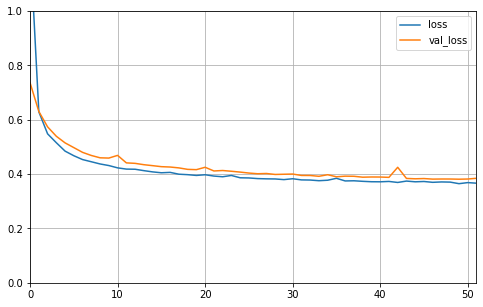

In [7]:
#打印模型训练过程中的相关曲线
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
'''
for lr, history in zip(learning_rates, histories):#并行遍历，lr遍历learning_rate， history遍历histories
    print("learning_rate:",lr)
    plot_learning_curves(history)
'''
plot_learning_curves(history)

In [8]:
#model.evaluate(x_test_scaler,y_test)#sklearn中的model没有evaluate函数

In [9]:
from scipy.stats import reciprocal
#分布函数f(x) = 1/(x*log(b/a)) a <= x <= b

#在1e-4至1e-2之间取10个数，看下示例，注释运行
#reciprocal.rvs(1e-4,1e-2,size=10) 
#array([0.00194792, 0.0030323 , 0.00012433, 0.00113947, 0.00015001,
#       0.0085196 , 0.00514795, 0.00038299, 0.00644926, 0.00039257])

#定义一个参数分布，这个参数分布里面的参数(hidden_layers、layers_size、learning_rate)设置取决于前面封装的build_model接口参数
param_distribution={
    "hidden_layers":[1,2,3,4],
    #这里sklearn的版本必须是 0.21.3，不然下面的写法会报错
    "layers_size":np.arange(1, 40),#取值为 [1,2,3...98,99,100]
    "learning_rate":reciprocal(1e-4,1e-2),#lr是一个连续取值，使用分布来取learning_rate值
    
    #在最新版sklearn0.22.2版本中上面的搜索写法执行报错，只能用下面普通列表才不会报错，但是这样写实际上意义不是很大
    #"layers_size": [5, 10, 20, 30, 40, 50],
    #"learning_rate": [1e-4, 5e-5, 1e-3, 5e-3, 1e-2],    
}

from sklearn.model_selection import RandomizedSearchCV

#n_iter:从前面的参数分布中取出的参数组的个数; n_jobs:并行化处理的任务个数
random_search_cv=RandomizedSearchCV(sklearn_model,param_distribution,n_iter=10,n_jobs=1)
random_search_cv.fit(x_train_scaler,y_train,epochs=30,validation_data=(x_valid_scaler,y_valid),callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 91us/sample - loss: 3.7549 - val_loss: 2.5928
Epoch 2/30
7740/7740 [==============================] - 0s 64us/sample - loss: 1.8982 - val_loss: 1.5324
Epoch 3/30
7740/7740 [==============================] - 0s 54us/sample - loss: 1.2397 - val_loss: 1.1008
Epoch 4/30
7740/7740 [==============================] - 0s 55us/sample - loss: 0.9569 - val_loss: 0.9141
Epoch 5/30
7740/7740 [==============================] - 0s 54us/sample - loss: 0.8295 - val_loss: 0.8305
Epoch 6/30
7740/7740 [==============================] - 0s 60us/sample - loss: 0.7694 - val_loss: 0.7889
Epoch 7/30
7740/7740 [==============================] - 0s 55us/sample - loss: 0.7371 - val_loss: 0.7646
Epoch 8/30
7740/7740 [==============================] - 0s 54us/sample - loss: 0.7166 - val_loss: 0.7474
Epoch 9/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7014 - val_loss: 0.7333
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 88us/sample - loss: 2.6694 - val_loss: 1.7703
Epoch 2/30
7740/7740 [==============================] - 1s 66us/sample - loss: 1.3849 - val_loss: 1.1117
Epoch 3/30
7740/7740 [==============================] - 1s 69us/sample - loss: 0.9725 - val_loss: 0.8957
Epoch 4/30
7740/7740 [==============================] - 0s 55us/sample - loss: 0.8130 - val_loss: 0.8141
Epoch 5/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7434 - val_loss: 0.7779
Epoch 6/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.7077 - val_loss: 0.7583
Epoch 7/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6857 - val_loss: 0.7440
Epoch 8/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.6701 - val_loss: 0.7334
Epoch 9/30
7740/7740 [==============================] - 0s 60us/sample - loss: 0.6578 - val_loss: 0.7234
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 91us/sample - loss: 3.0149 - val_loss: 2.0300
Epoch 2/30
7740/7740 [==============================] - 0s 57us/sample - loss: 1.5472 - val_loss: 1.2741
Epoch 3/30
7740/7740 [==============================] - 0s 56us/sample - loss: 1.0538 - val_loss: 0.9967
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.8637 - val_loss: 0.8899
Epoch 5/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.7842 - val_loss: 0.8431
Epoch 6/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7448 - val_loss: 0.8175
Epoch 7/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7203 - val_loss: 0.7977
Epoch 8/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7012 - val_loss: 0.7802
Epoch 9/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.6848 - val_loss: 0.7643
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 91us/sample - loss: 3.6477 - val_loss: 2.2174
Epoch 2/30
7740/7740 [==============================] - 0s 63us/sample - loss: 1.6123 - val_loss: 1.4804
Epoch 3/30
7740/7740 [==============================] - 1s 65us/sample - loss: 1.2815 - val_loss: 1.2821
Epoch 4/30
7740/7740 [==============================] - 0s 61us/sample - loss: 1.1381 - val_loss: 1.1507
Epoch 5/30
7740/7740 [==============================] - 0s 61us/sample - loss: 1.0308 - val_loss: 1.0447
Epoch 6/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.9451 - val_loss: 0.9597
Epoch 7/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.8764 - val_loss: 0.8907
Epoch 8/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.8214 - val_loss: 0.8359
Epoch 9/30
7740/7740 [==============================] - 0s 60us/sample - loss: 0.7775 - val_loss: 0.7911
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 102us/sample - loss: 1.8362 - val_loss: 1.2490
Epoch 2/30
7740/7740 [==============================] - 0s 61us/sample - loss: 1.0387 - val_loss: 1.0227
Epoch 3/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.9046 - val_loss: 0.9164
Epoch 4/30
7740/7740 [==============================] - 0s 64us/sample - loss: 0.8359 - val_loss: 0.8597
Epoch 5/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7940 - val_loss: 0.8228
Epoch 6/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7642 - val_loss: 0.7982
Epoch 7/30
7740/7740 [==============================] - 0s 63us/sample - loss: 0.7422 - val_loss: 0.7793
Epoch 8/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7239 - val_loss: 0.7648
Epoch 9/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7083 - val_loss: 0.7509
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 102us/sample - loss: 3.1173 - val_loss: 2.0771
Epoch 2/30
7740/7740 [==============================] - 0s 62us/sample - loss: 1.5069 - val_loss: 1.2703
Epoch 3/30
7740/7740 [==============================] - 0s 62us/sample - loss: 1.0807 - val_loss: 1.0275
Epoch 4/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.9215 - val_loss: 0.8952
Epoch 5/30
7740/7740 [==============================] - 0s 63us/sample - loss: 0.8129 - val_loss: 0.8110
Epoch 6/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7406 - val_loss: 0.7631
Epoch 7/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.6971 - val_loss: 0.7362
Epoch 8/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6710 - val_loss: 0.7198
Epoch 9/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6543 - val_loss: 0.7094
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 99us/sample - loss: 4.1626 - val_loss: 3.0992
Epoch 2/30
7740/7740 [==============================] - 1s 66us/sample - loss: 1.9688 - val_loss: 1.3010
Epoch 3/30
7740/7740 [==============================] - 0s 65us/sample - loss: 1.0030 - val_loss: 0.9623
Epoch 4/30
7740/7740 [==============================] - 1s 65us/sample - loss: 0.8708 - val_loss: 0.8866
Epoch 5/30
7740/7740 [==============================] - 0s 64us/sample - loss: 0.8156 - val_loss: 0.8356
Epoch 6/30
7740/7740 [==============================] - 1s 65us/sample - loss: 0.7783 - val_loss: 0.8016
Epoch 7/30
7740/7740 [==============================] - 0s 65us/sample - loss: 0.7533 - val_loss: 0.7776
Epoch 8/30
7740/7740 [==============================] - 1s 65us/sample - loss: 0.7353 - val_loss: 0.7605
Epoch 9/30
7740/7740 [==============================] - 1s 65us/sample - loss: 0.7220 - val_loss: 0.7479
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 109us/sample - loss: 2.6066 - val_loss: 1.2394
Epoch 2/30
7740/7740 [==============================] - 0s 64us/sample - loss: 1.0549 - val_loss: 0.9732
Epoch 3/30
7740/7740 [==============================] - 0s 64us/sample - loss: 0.9168 - val_loss: 0.9013
Epoch 4/30
7740/7740 [==============================] - 1s 65us/sample - loss: 0.8613 - val_loss: 0.8545
Epoch 5/30
7740/7740 [==============================] - 1s 65us/sample - loss: 0.8190 - val_loss: 0.8185
Epoch 6/30
7740/7740 [==============================] - 0s 65us/sample - loss: 0.7844 - val_loss: 0.7899
Epoch 7/30
7740/7740 [==============================] - 0s 64us/sample - loss: 0.7564 - val_loss: 0.7670
Epoch 8/30
7740/7740 [==============================] - 1s 66us/sample - loss: 0.7333 - val_loss: 0.7480
Epoch 9/30
7740/7740 [==============================] - 1s 66us/sample - loss: 0.7139 - val_loss: 0.7320
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 99us/sample - loss: 4.2664 - val_loss: 2.8048
Epoch 2/30
7740/7740 [==============================] - 1s 66us/sample - loss: 2.0105 - val_loss: 1.7555
Epoch 3/30
7740/7740 [==============================] - 1s 65us/sample - loss: 1.5004 - val_loss: 1.4925
Epoch 4/30
7740/7740 [==============================] - 1s 67us/sample - loss: 1.3391 - val_loss: 1.3687
Epoch 5/30
7740/7740 [==============================] - 1s 65us/sample - loss: 1.2556 - val_loss: 1.2947
Epoch 6/30
7740/7740 [==============================] - 1s 73us/sample - loss: 1.1976 - val_loss: 1.2436
Epoch 7/30
7740/7740 [==============================] - 1s 72us/sample - loss: 1.1551 - val_loss: 1.1942
Epoch 8/30
7740/7740 [==============================] - 0s 63us/sample - loss: 1.1102 - val_loss: 1.1417
Epoch 9/30
7740/7740 [==============================] - 0s 60us/sample - loss: 1.0595 - val_loss: 1.0846
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 96us/sample - loss: 3.7005 - val_loss: 2.7899
Epoch 2/30
7740/7740 [==============================] - 0s 60us/sample - loss: 2.1201 - val_loss: 1.7748
Epoch 3/30
7740/7740 [==============================] - 0s 53us/sample - loss: 1.4480 - val_loss: 1.3186
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 1.1333 - val_loss: 1.0926
Epoch 5/30
7740/7740 [==============================] - 0s 54us/sample - loss: 0.9714 - val_loss: 0.9706
Epoch 6/30
7740/7740 [==============================] - 0s 53us/sample - loss: 0.8810 - val_loss: 0.8993
Epoch 7/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.8267 - val_loss: 0.8548
Epoch 8/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7917 - val_loss: 0.8248
Epoch 9/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7672 - val_loss: 0.8029
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 76us/sample - loss: 4.2188 - val_loss: 3.5465
Epoch 2/30
7740/7740 [==============================] - 0s 51us/sample - loss: 2.8591 - val_loss: 2.5166
Epoch 3/30
7740/7740 [==============================] - 0s 52us/sample - loss: 2.0722 - val_loss: 1.8964
Epoch 4/30
7740/7740 [==============================] - 0s 51us/sample - loss: 1.5903 - val_loss: 1.5064
Epoch 5/30
7740/7740 [==============================] - 0s 52us/sample - loss: 1.2822 - val_loss: 1.2560
Epoch 6/30
7740/7740 [==============================] - 0s 52us/sample - loss: 1.0834 - val_loss: 1.0913
Epoch 7/30
7740/7740 [==============================] - 0s 53us/sample - loss: 0.9525 - val_loss: 0.9808
Epoch 8/30
7740/7740 [==============================] - 0s 52us/sample - loss: 0.8643 - val_loss: 0.9039
Epoch 9/30
7740/7740 [==============================] - 0s 51us/sample - loss: 0.8034 - val_loss: 0.8492
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 87us/sample - loss: 2.8387 - val_loss: 2.2943
Epoch 2/30
7740/7740 [==============================] - 0s 52us/sample - loss: 1.7387 - val_loss: 1.6234
Epoch 3/30
7740/7740 [==============================] - 0s 52us/sample - loss: 1.2808 - val_loss: 1.3163
Epoch 4/30
7740/7740 [==============================] - 0s 52us/sample - loss: 1.0623 - val_loss: 1.1527
Epoch 5/30
7740/7740 [==============================] - 0s 53us/sample - loss: 0.9475 - val_loss: 1.0587
Epoch 6/30
7740/7740 [==============================] - 0s 52us/sample - loss: 0.8836 - val_loss: 1.0001
Epoch 7/30
7740/7740 [==============================] - 0s 53us/sample - loss: 0.8453 - val_loss: 0.9614
Epoch 8/30
7740/7740 [==============================] - 0s 52us/sample - loss: 0.8205 - val_loss: 0.9338
Epoch 9/30
7740/7740 [==============================] - 0s 53us/sample - loss: 0.8032 - val_loss: 0.9135
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 92us/sample - loss: 1.0487 - val_loss: 0.6112
Epoch 2/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5500 - val_loss: 0.5399
Epoch 3/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4946 - val_loss: 0.5015
Epoch 4/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4659 - val_loss: 0.4644
Epoch 5/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4424 - val_loss: 0.4638
Epoch 6/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4275 - val_loss: 0.4318
Epoch 7/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.4049 - val_loss: 0.4124
Epoch 8/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.3948 - val_loss: 0.4022
Epoch 9/30
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3888 - val_loss: 0.3949
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 106us/sample - loss: 1.6985 - val_loss: 0.8703
Epoch 2/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6635 - val_loss: 0.6630
Epoch 3/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6553 - val_loss: 0.7076
Epoch 4/30
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5706 - val_loss: 0.5365
Epoch 5/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4804 - val_loss: 0.5103
Epoch 6/30
7740/7740 [==============================] - 0s 60us/sample - loss: 0.4512 - val_loss: 0.4700
Epoch 7/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.4262 - val_loss: 0.4368
Epoch 8/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.4035 - val_loss: 0.4166
Epoch 9/30
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3884 - val_loss: 0.4065
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 93us/sample - loss: 1.2515 - val_loss: 0.7251
Epoch 2/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5869 - val_loss: 0.6059
Epoch 3/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5039 - val_loss: 0.5400
Epoch 4/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4527 - val_loss: 0.4838
Epoch 5/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.4179 - val_loss: 0.4555
Epoch 6/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.3973 - val_loss: 0.4382
Epoch 7/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.3814 - val_loss: 0.4127
Epoch 8/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.3717 - val_loss: 0.4078
Epoch 9/30
7740/7740 [==============================] - 0s 61us/sample - loss: 0.3636 - val_loss: 0.4076
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 88us/sample - loss: 2.0076 - val_loss: 1.1214
Epoch 2/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.9552 - val_loss: 0.9018
Epoch 3/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.8182 - val_loss: 0.8244
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.7565 - val_loss: 0.7775
Epoch 5/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.7164 - val_loss: 0.7408
Epoch 6/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6845 - val_loss: 0.7117
Epoch 7/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.6582 - val_loss: 0.6862
Epoch 8/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.6350 - val_loss: 0.6629
Epoch 9/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6142 - val_loss: 0.6421
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 88us/sample - loss: 2.1661 - val_loss: 1.1378
Epoch 2/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.8960 - val_loss: 0.8321
Epoch 3/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.7447 - val_loss: 0.7417
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6824 - val_loss: 0.6947
Epoch 5/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.6433 - val_loss: 0.6585
Epoch 6/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.6127 - val_loss: 0.6324
Epoch 7/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5886 - val_loss: 0.6095
Epoch 8/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5680 - val_loss: 0.5912
Epoch 9/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5512 - val_loss: 0.5758
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 88us/sample - loss: 2.0090 - val_loss: 1.1564
Epoch 2/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.8972 - val_loss: 0.8563
Epoch 3/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.7289 - val_loss: 0.7656
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6686 - val_loss: 0.7217
Epoch 5/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6344 - val_loss: 0.6928
Epoch 6/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6083 - val_loss: 0.6655
Epoch 7/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5865 - val_loss: 0.6442
Epoch 8/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5676 - val_loss: 0.6239
Epoch 9/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5506 - val_loss: 0.6087
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 103us/sample - loss: 1.6905 - val_loss: 0.8450
Epoch 2/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.8114 - val_loss: 0.7991
Epoch 3/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6727 - val_loss: 0.6672
Epoch 4/30
7740/7740 [==============================] - 0s 62us/sample - loss: 0.6208 - val_loss: 0.6289
Epoch 5/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5870 - val_loss: 0.5966
Epoch 6/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5605 - val_loss: 0.5736
Epoch 7/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5390 - val_loss: 0.5539
Epoch 8/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5214 - val_loss: 0.5324
Epoch 9/30
7740/7740 [==============================] - 0s 60us/sample - loss: 0.5073 - val_loss: 0.5177
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 88us/sample - loss: 2.1737 - val_loss: 1.1586
Epoch 2/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.8778 - val_loss: 0.7865
Epoch 3/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6744 - val_loss: 0.6979
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6222 - val_loss: 0.6599
Epoch 5/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5912 - val_loss: 0.6319
Epoch 6/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5680 - val_loss: 0.6082
Epoch 7/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5479 - val_loss: 0.5877
Epoch 8/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5324 - val_loss: 0.5722
Epoch 9/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5183 - val_loss: 0.5581
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 87us/sample - loss: 1.8665 - val_loss: 0.8896
Epoch 2/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.7280 - val_loss: 0.7296
Epoch 3/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6415 - val_loss: 0.6773
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5970 - val_loss: 0.6399
Epoch 5/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5625 - val_loss: 0.6088
Epoch 6/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5368 - val_loss: 0.5868
Epoch 7/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5169 - val_loss: 0.5647
Epoch 8/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5003 - val_loss: 0.5441
Epoch 9/30
7740/7740 [==============================] - 0s 59us/sample - loss: 0.4857 - val_loss: 0.5292
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 84us/sample - loss: 2.7127 - val_loss: 1.2139
Epoch 2/30
7740/7740 [==============================] - 0s 60us/sample - loss: 0.9439 - val_loss: 0.8399
Epoch 3/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7792 - val_loss: 0.7893
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.7351 - val_loss: 0.7575
Epoch 5/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.7038 - val_loss: 0.7311
Epoch 6/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6785 - val_loss: 0.7057
Epoch 7/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6554 - val_loss: 0.6818
Epoch 8/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6349 - val_loss: 0.6617
Epoch 9/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6158 - val_loss: 0.6426
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 83us/sample - loss: 2.7110 - val_loss: 1.2938
Epoch 2/30
7740/7740 [==============================] - 0s 55us/sample - loss: 0.9110 - val_loss: 0.8194
Epoch 3/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7308 - val_loss: 0.7548
Epoch 4/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.6811 - val_loss: 0.7207
Epoch 5/30
7740/7740 [==============================] - 0s 55us/sample - loss: 0.6504 - val_loss: 0.6926
Epoch 6/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.6268 - val_loss: 0.6701
Epoch 7/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6064 - val_loss: 0.6495
Epoch 8/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.5894 - val_loss: 0.6326
Epoch 9/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.5739 - val_loss: 0.6162
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 82us/sample - loss: 2.8188 - val_loss: 1.5109
Epoch 2/30
7740/7740 [==============================] - 0s 55us/sample - loss: 1.1016 - val_loss: 0.9520
Epoch 3/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.7913 - val_loss: 0.7826
Epoch 4/30
7740/7740 [==============================] - 0s 55us/sample - loss: 0.6864 - val_loss: 0.7254
Epoch 5/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6418 - val_loss: 0.6985
Epoch 6/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.6142 - val_loss: 0.6737
Epoch 7/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.5949 - val_loss: 0.6551
Epoch 8/30
7740/7740 [==============================] - 0s 55us/sample - loss: 0.5773 - val_loss: 0.6395
Epoch 9/30
7740/7740 [==============================] - 0s 55us/sample - loss: 0.5619 - val_loss: 0.6213
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 91us/sample - loss: 5.8425 - val_loss: 5.0501
Epoch 2/30
7740/7740 [==============================] - 1s 71us/sample - loss: 4.2098 - val_loss: 3.8305
Epoch 3/30
7740/7740 [==============================] - 1s 80us/sample - loss: 3.2228 - val_loss: 2.9255
Epoch 4/30
7740/7740 [==============================] - 1s 73us/sample - loss: 2.4466 - val_loss: 2.1922
Epoch 5/30
7740/7740 [==============================] - 1s 74us/sample - loss: 1.8438 - val_loss: 1.6484
Epoch 6/30
7740/7740 [==============================] - 1s 65us/sample - loss: 1.4409 - val_loss: 1.3181
Epoch 7/30
7740/7740 [==============================] - 1s 70us/sample - loss: 1.2169 - val_loss: 1.1468
Epoch 8/30
7740/7740 [==============================] - 1s 69us/sample - loss: 1.1068 - val_loss: 1.0632
Epoch 9/30
7740/7740 [==============================] - 1s 72us/sample - loss: 1.0532 - val_loss: 1.0213
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 100us/sample - loss: 4.9193 - val_loss: 4.1527
Epoch 2/30
7740/7740 [==============================] - 0s 63us/sample - loss: 3.2706 - val_loss: 2.8093
Epoch 3/30
7740/7740 [==============================] - 0s 63us/sample - loss: 2.2038 - val_loss: 1.9894
Epoch 4/30
7740/7740 [==============================] - 0s 64us/sample - loss: 1.6368 - val_loss: 1.6162
Epoch 5/30
7740/7740 [==============================] - 1s 65us/sample - loss: 1.3895 - val_loss: 1.4418
Epoch 6/30
7740/7740 [==============================] - 1s 68us/sample - loss: 1.2547 - val_loss: 1.3261
Epoch 7/30
7740/7740 [==============================] - 1s 65us/sample - loss: 1.1609 - val_loss: 1.2356
Epoch 8/30
7740/7740 [==============================] - 0s 63us/sample - loss: 1.0885 - val_loss: 1.1608
Epoch 9/30
7740/7740 [==============================] - 1s 73us/sample - loss: 1.0297 - val_loss: 1.0982
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 114us/sample - loss: 4.3658 - val_loss: 4.1591
Epoch 2/30
7740/7740 [==============================] - 0s 63us/sample - loss: 3.5915 - val_loss: 3.3931
Epoch 3/30
7740/7740 [==============================] - 1s 65us/sample - loss: 2.9149 - val_loss: 2.7511
Epoch 4/30
7740/7740 [==============================] - 0s 64us/sample - loss: 2.3871 - val_loss: 2.2780
Epoch 5/30
7740/7740 [==============================] - 1s 65us/sample - loss: 2.0334 - val_loss: 1.9800
Epoch 6/30
7740/7740 [==============================] - 0s 64us/sample - loss: 1.8143 - val_loss: 1.7939
Epoch 7/30
7740/7740 [==============================] - 1s 66us/sample - loss: 1.6709 - val_loss: 1.6672
Epoch 8/30
7740/7740 [==============================] - 1s 65us/sample - loss: 1.5644 - val_loss: 1.5686
Epoch 9/30
7740/7740 [==============================] - 0s 64us/sample - loss: 1.4784 - val_loss: 1.4893
Epoch 

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 85us/sample - loss: 1.4532 - val_loss: 0.6823
Epoch 2/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5917 - val_loss: 0.5766
Epoch 3/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5180 - val_loss: 0.5201
Epoch 4/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4798 - val_loss: 0.4757
Epoch 5/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4525 - val_loss: 0.4496
Epoch 6/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4418 - val_loss: 0.4362
Epoch 7/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4223 - val_loss: 0.4191
Epoch 8/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4185 - val_loss: 0.4141
Epoch 9/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4075 - val_loss: 0.4089
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 85us/sample - loss: 1.3655 - val_loss: 0.8007
Epoch 2/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6965 - val_loss: 0.6946
Epoch 3/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.6209 - val_loss: 0.6310
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5644 - val_loss: 0.5662
Epoch 5/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5062 - val_loss: 0.5127
Epoch 6/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4680 - val_loss: 0.4855
Epoch 7/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4453 - val_loss: 0.4613
Epoch 8/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4424 - val_loss: 0.4595
Epoch 9/30
7740/7740 [==============================] - 0s 56us/sample - loss: 0.4299 - val_loss: 0.4731
Epoch 1

Train on 7740 samples, validate on 3870 samples
Epoch 1/30
7740/7740 [==============================] - 1s 84us/sample - loss: 1.6009 - val_loss: 0.9856
Epoch 2/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.9710 - val_loss: 0.6870
Epoch 3/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5744 - val_loss: 0.5889
Epoch 4/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.5117 - val_loss: 0.5394
Epoch 5/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4758 - val_loss: 0.5025
Epoch 6/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.4473 - val_loss: 0.4772
Epoch 7/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4241 - val_loss: 0.4561
Epoch 8/30
7740/7740 [==============================] - 0s 57us/sample - loss: 0.4054 - val_loss: 0.4330
Epoch 9/30
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3941 - val_loss: 0.4228
Epoch 1

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 80us/sample - loss: 0.9175 - val_loss: 0.6106
Epoch 2/30
11610/11610 [==============================] - 1s 58us/sample - loss: 0.5088 - val_loss: 0.4868
Epoch 3/30
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4441 - val_loss: 0.4408
Epoch 4/30
11610/11610 [==============================] - 1s 57us/sample - loss: 0.3901 - val_loss: 0.3856
Epoch 5/30
11610/11610 [==============================] - 1s 58us/sample - loss: 0.3723 - val_loss: 0.3831
Epoch 6/30
11610/11610 [==============================] - 1s 59us/sample - loss: 0.3615 - val_loss: 0.3699
Epoch 7/30
11610/11610 [==============================] - 1s 59us/sample - loss: 0.3539 - val_loss: 0.3750
Epoch 8/30
11610/11610 [==============================] - 1s 58us/sample - loss: 0.3484 - val_loss: 0.3814
Epoch 9/30
11610/11610 [==============================] - 1s 58us/sample - loss: 0.3436 - val_l

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f01f9d40240>,
                   iid='warn', n_iter=10, n_jobs=1,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layers_size': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39]),
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f01f9ffcd68>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [10]:
#打印最优的超参数的数据
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

{'hidden_layers': 4, 'layers_size': 23, 'learning_rate': 0.00650462432478528}
-0.3407047720714236


In [11]:
#获取最优超参数的模型并在测试集上验证下
model=random_search_cv.best_estimator_.model
model.evaluate(x_test_scaler,y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.3205111207426056